In [1]:
import sys
sys.path.insert(0,'..')
from wavhandler import *
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils_train import train_test_val_split, TrainConfiguration, train_generator
from utils_train import valid_generator,mosquito_data_split, train_model_ml
import deepdish as dd
from joblib import dump, load
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
seed = 42
np.random.seed(seed=seed)

splitting = "random"
data_setting = "psdHQ"
model_setting = "xgboost"

assert splitting in ['random','randomcv','custom'], "Wrong splitting method given."
assert data_setting in ['raw','psd_dB','psdHQ'], "Wrong data settting given."
assert model_setting in ['knn','randomforest','xgboost']

data = Dataset('Wingbeats')
print(data.target_classes)

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']


In [2]:
print(f'SPLITTING DATA {splitting}')
X_train, X_val, X_test, y_train, y_val, y_test = mosquito_data_split(splitting=splitting, dataset=data)

SPLITTING DATA random
Species: Ae. aegypti.
Read 85553 filenames in 6.11 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 1.34 seconds.
Species: An. arabiensis.
Read 19297 filenames in 1.43 seconds.
Species: An. gambiae.
Read 49471 filenames in 1.36 seconds.
Species: C. pipiens.
Read 30415 filenames in 1.44 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 1.38 seconds.


In [3]:
x_test = make_df_parallel(names=X_test, setting=data_setting).values

## if "RANDOM"

In [ ]:
results = {}
if splitting in ['random', 'randomcv']:
    X_train.extend(X_val)
    y_train.extend(y_val)
    x_train = make_df_parallel(names=X_train, setting=data_setting).values
    x_val = make_df_parallel(names=X_val, setting=data_setting).values

    model, res = train_model_ml(dataset=data,
                            model_setting=model_setting,
                            splitting=splitting, 
                            data_setting=data_setting,
                            x_train=x_train, 
                            y_train=y_train, 
                            x_val=x_val, 
                            y_val=y_val, 
                            x_test=x_test, 
                            y_test=y_test,
                            flag='ML')
    results[splitting] = res

## if "CUSTOM"

In [ ]:
if splitting == 'custom':
    train_scores, val_scores, cms, b_accs, logloss, clf_reports, y_preds, y_pred_probas = [],[],[],[],[],[],[],[]
    for i in range(5):
        x_train_fold = make_df_parallel(names=X_train[i], setting=data_setting).values
        x_val_fold = make_df_parallel(names=X_val[i], setting=data_setting).values
        estimator = train_model_ml(dataset=data,
                                    model_setting=model_setting,
                                    splitting=splitting, 
                                    data_setting=data_setting,
                                    x_train=x_train_fold, 
                                    y_train=y_train[i], 
                                    x_val=x_val_fold, 
                                    y_val=y_val[i], 
                                    x_test=x_test, 
                                    y_test=y_test,
                                    flag=f'split_{i}')

        y_preds.append( estimator.predict(x_test) )
        y_pred_probas.append( estimator.predict_proba(x_test) )
        train_scores.append( balanced_accuracy_score(y_train[i], estimator.predict(x_train_fold)) )
        val_scores.append( balanced_accuracy_score(y_val[i], estimator.predict(x_val_fold)) )
        cms.append(confusion_matrix(y_test, y_preds[i]))
        b_accs.append(balanced_accuracy_score(y_test, y_preds[i]))
        logloss.append(log_loss(y_test, y_pred_probas[i]))
        clf_reports.append(classification_report(y_test, y_preds[i], target_names=data.target_classes))

    mean_train_score = np.mean(train_scores)
    mean_val_score = np.mean(val_scores)
    mean_test_score = np.mean(b_accs)
    mean_test_logloss = np.mean(logloss)
    
    results['y_preds'] = y_preds
    results['y_pred_probas'] = y_pred_probas
    results['y_test'] = y_test
    results['cms'] = cms
    results['b_accs'] = b_accs
    results['logloss'] = logloss
    results['clf_reports'] = clf_reports
    results['train_score'] = mean_train_score
    results['val_score'] = mean_val_score
    results['balanced_acc_test'] = mean_test_score
    results['logloss_test'] = mean_test_logloss

In [ ]:
dd.io.save(f'{TEMP_DATADIR}/{splitting}_{data_setting}_{model_setting}_results.h5', 
            {f'results': results})

In [4]:
f = f'{TEMP_DATADIR}/{splitting}_{data_setting}_{model_setting}_results.h5'
d = dd.io.load(f)['results']

dict_keys(['b_accs', 'clf_reports', 'cms', 'logloss', 'y_pred_probas', 'y_preds', 'balanced_acc_test', 'logloss_test', 'train_score', 'val_score'])

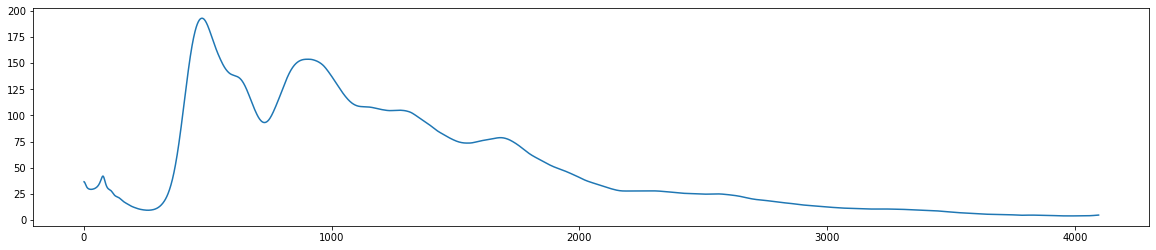

In [81]:
df = pd.DataFrame(x_test)
plt.figure(figsize=(20,4))
df.var().plot()

In [65]:
series = df.var()>50
series.where(series>0).dropna()

367     1.0
368     1.0
369     1.0
370     1.0
371     1.0
       ... 
1902    1.0
1903    1.0
1904    1.0
1905    1.0
1906    1.0
Length: 1540, dtype: float64

In [66]:
x_train = make_df_parallel(names=X_train, setting=data_setting).values

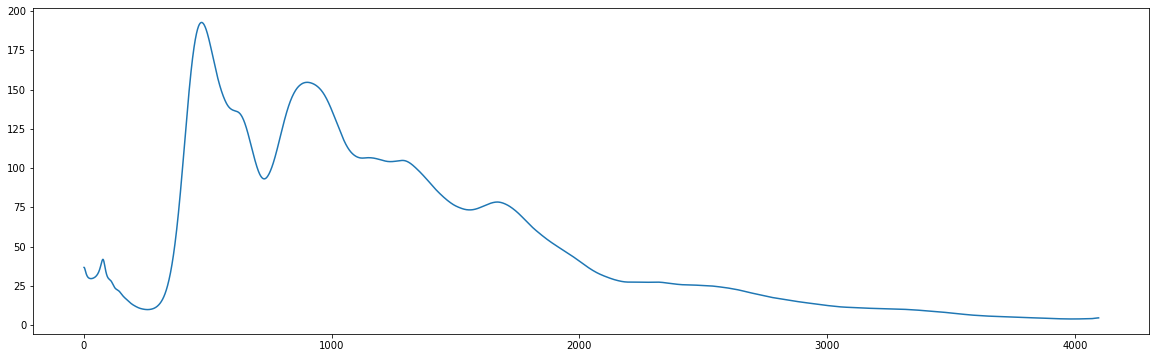

In [80]:
df = pd.DataFrame(x_train)
plt.figure(figsize=(20,6))
df.var().plot()

In [76]:
series = df.var()>50
series.where(series>0).dropna()

366     1.0
367     1.0
368     1.0
369     1.0
370     1.0
       ... 
1908    1.0
1909    1.0
1910    1.0
1911    1.0
1912    1.0
Length: 1547, dtype: float64

In [78]:
series.iloc[366:1913]

366     True
367     True
368     True
369     True
370     True
        ... 
1908    True
1909    True
1910    True
1911    True
1912    True
Length: 1547, dtype: bool